In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS
import string
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from gensim.models import Word2Vec, FastText
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix , classification_report
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

In [2]:
DATASET_ROOT = 'dataset/'
email_dataset = pd.read_csv(f'{DATASET_ROOT}spam_ham_dataset.csv')
email_dataset = email_dataset.drop(['Unnamed: 0', 'label'], axis=1)
email_dataset.columns = ['text', 'label']

HAM = 0
SPAM = 1

In [3]:
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    return text

def make_wordcloud(corpus , stopword):
    word_cloud = WordCloud(
            width=3000,
            height=2000,
            random_state=1,
            background_color="black",
            colormap="Pastel1",
            collocations=False,
            stopwords=stopword,
            ).generate(corpus)
    return word_cloud

In [4]:
email_dataset.head()

,text,label
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


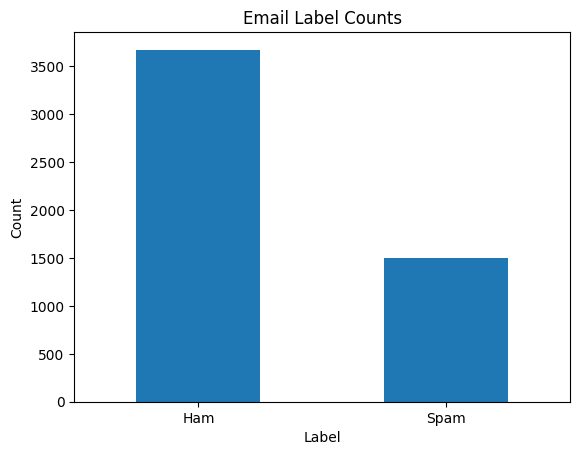

In [5]:
label_col = email_dataset['label'].value_counts()
label_col.plot.bar()

plt.title("Email Label Counts")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks([0, 1], ['Ham', 'Spam'], rotation=0)

# display the chart
plt.show()

In [6]:
subjects = []
text = []
for i in range(len(email_dataset)):
    ln = email_dataset["text"][i]
    line = ""
    for i in ln:
        if(i == '\r'):
            break
        line = line + i
    ln = ln.replace(line , "")
    line = line.replace("Subject:" , "")
    text.append(ln)
    subjects.append(line)

email_dataset["subject"] = subjects
email_dataset["text"] = text

In [7]:
email_dataset = swap_columns(email_dataset, 'subject', 'label')
email_dataset.head()

,text,subject,label
0,\r\nthis is a follow up to the note i gave you...,enron methanol ; meter # : 988291,0
1,\r\n( see attached file : hplnol 09 . xls )\r\...,"hpl nom for january 9 , 2001",0
2,"\r\nho ho ho , we ' re around to that most won...",neon retreat,0
3,\r\nabasements darer prudently fortuitous unde...,"photoshop , windows , office . cheap . main t...",1
4,\r\nthis deal is to book the teco pvr revenue ...,re : indian springs,0


In [8]:
from tqdm.auto import tqdm
tqdm.pandas()

email_dataset['subject'] = email_dataset['subject'].str.lower()
email_dataset['text'] = email_dataset['text'].str.lower()

email_dataset['subject'] = email_dataset['subject'].apply(remove_punctuations)
email_dataset['text'] = email_dataset['text'].progress_apply(remove_punctuations)

email_dataset.head()

100%|██████████| 5171/5171 [00:00<00:00, 59965.51it/s]


,text,subject,label
0,this is a follow up to the note i gave you o...,enron methanol meter 988291,0
1,see attached file hplnol 09 xls hplnol...,hpl nom for january 9 2001,0
2,ho ho ho we re around to that most wonderf...,neon retreat,0
3,abasements darer prudently fortuitous underg...,photoshop windows office cheap main trending,1
4,this deal is to book the teco pvr revenue i...,re indian springs,0


In [9]:
#Creting seprate dataset for Spam and Non Spam emails, to perform analysis 
Spam = pd.DataFrame(columns = ['text', 'subject', 'label'])
Non_Spam = pd.DataFrame(columns = ['text', 'subject', 'label'])

In [10]:
# Creating Non_Spam email dataset 
for i in range(len(email_dataset)):
    if(email_dataset['label'][i] == HAM):
        new_row = {'text':email_dataset['text'][i], 'subject':email_dataset['subject'][i], 'label':email_dataset['label'][i]}
        Non_Spam.loc[len(Non_Spam)] = new_row

# Creating Spam email dataset
for i in range(len(email_dataset)):
    if(email_dataset['label'][i] == SPAM):
        new_row = {'text':email_dataset['text'][i], 'subject':email_dataset['subject'][i], 'label':email_dataset['label'][i]}
        Spam.loc[len(Spam)] = new_row

In [11]:
Spam.head()

,text,subject,label
0,abasements darer prudently fortuitous underg...,photoshop windows office cheap main trending,1
1,it is difficult to make our material conditi...,looking for medication we re the best source,1
2,vcsc brand new stock for your attention vo...,vocable rnd word asceticism,1
3,wffur attion brom est inst siupied 1 pgst ou...,report 01405,1
4,berne hotbox carnal bride cutworm dyadic gu...,vic odin n ow,1


In [12]:
Non_Spam.head()

,text,subject,label
0,this is a follow up to the note i gave you o...,enron methanol meter 988291,0
1,see attached file hplnol 09 xls hplnol...,hpl nom for january 9 2001,0
2,ho ho ho we re around to that most wonderf...,neon retreat,0
3,this deal is to book the teco pvr revenue i...,re indian springs,0
4,this message is intended for ehronline users...,ehronline web address change,0


In [13]:
#creating stopwords corpus
more_stopwords = {'re' , 's' , 'subject','hpl','hou','enron'}
STOPWORDS = STOPWORDS.union(more_stopwords)

#creating spam subject corpus 
subject_corpus_spam = ""
for i in range(len(Spam)):
    subject_corpus_spam = subject_corpus_spam + Spam['subject'][i]

#creating spam text corpus 
text_corpus_spam = ""
for i in range(len(Spam)):
    text_corpus_spam = text_corpus_spam + Spam['text'][i]

#creating non-spam subject corpus 
subject_corpus_non_spam = ""
for i in range(len(Non_Spam)):
    subject_corpus_non_spam = subject_corpus_non_spam + Non_Spam['subject'][i]

#creating non-spam text corpus 
text_corpus_non_spam = ""
for i in range(len(Non_Spam)):
    text_corpus_non_spam = text_corpus_non_spam + Non_Spam['text'][i]

In [14]:
#create a corpus conatininga all the email text 
email_text_corpus = []
for line in email_dataset['text']:
    words = line.split(" ")
    email_text_corpus.append(words)

#create a word2vec model for words in email text 
model = Word2Vec(email_text_corpus, min_count=1, vector_size=56)

In [15]:
X = model.wv[model.wv.key_to_index]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
pca_df = pd.DataFrame(result, columns = ['x','y'])

In [16]:
email_dataset.head()

,text,subject,label
0,this is a follow up to the note i gave you o...,enron methanol meter 988291,0
1,see attached file hplnol 09 xls hplnol...,hpl nom for january 9 2001,0
2,ho ho ho we re around to that most wonderf...,neon retreat,0
3,abasements darer prudently fortuitous underg...,photoshop windows office cheap main trending,1
4,this deal is to book the teco pvr revenue i...,re indian springs,0


In [17]:
# remove stopwords from the text and subject
email_dataset['text'] = email_dataset['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))
email_dataset['subject'] = email_dataset['subject'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))
email_dataset

,text,subject,label
0,follow note gave monday 4 3 00 preliminary flo...,methanol meter 988291,0
1,see attached file hplnol 09 xls hplnol 09 xls,nom january 9 2001,0
2,ho ho ho around wonderful time year neon leade...,neon retreat,0
3,abasements darer prudently fortuitous undergon...,photoshop windows office cheap main trending,1
4,deal book teco pvr revenue understanding teco ...,indian springs,0
...,...,...,...
5166,transport volumes decreased 25000 10000 10000 ...,put 10 ft,0
5167,t take extra 15 mmcf d weekend ll try next wee...,3 4 2000 following noms,0
5168,julie mention earlier hope start unit afternoo...,calpine daily gas nomination,0
5169,attached worksheets august 2000 activity three...,industrial worksheets august 2000 activity,0


# feature engineering


In [18]:
email_dataset['subject_len'] = email_dataset['subject'].apply(lambda x: len(x))
email_dataset['text_len'] = email_dataset['text'].apply(lambda x: len(x))
email_dataset['subject_word_count'] = email_dataset['subject'].apply(lambda x: len(x.split()))
email_dataset['text_word_count'] = email_dataset['text'].apply(lambda x: len(x.split()))

email_dataset.head()

,text,subject,label,subject_len,text_len,subject_word_count,text_word_count
0,follow note gave monday 4 3 00 preliminary flo...,methanol meter 988291,0,21,195,3,30
1,see attached file hplnol 09 xls hplnol 09 xls,nom january 9 2001,0,18,45,4,9
2,ho ho ho around wonderful time year neon leade...,neon retreat,0,12,1371,2,215
3,abasements darer prudently fortuitous undergon...,photoshop windows office cheap main trending,1,44,341,6,37
4,deal book teco pvr revenue understanding teco ...,indian springs,0,14,176,2,28


In [19]:
# average tf-idf score for the text and subject
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf.fit(email_dataset['text'])
text_tfidf = tfidf.transform(email_dataset['text'])
tfidf.fit(email_dataset['subject'])
subject_tfidf = tfidf.transform(email_dataset['subject'])

email_dataset['text_tfidf'] = text_tfidf.mean(axis=1)
email_dataset['subject_tfidf'] = subject_tfidf.mean(axis=1)

In [20]:
email_dataset.head()

,text,subject,label,subject_len,text_len,subject_word_count,text_word_count,text_tfidf,subject_tfidf
0,follow note gave monday 4 3 00 preliminary flo...,methanol meter 988291,0,21,195,3,30,0.000101,0.000337
1,see attached file hplnol 09 xls hplnol 09 xls,nom january 9 2001,0,18,45,4,9,0.000042,0.000348
2,ho ho ho around wonderful time year neon leade...,neon retreat,0,12,1371,2,215,0.000209,0.000282
3,abasements darer prudently fortuitous undergon...,photoshop windows office cheap main trending,1,44,341,6,37,0.000122,0.000492
4,deal book teco pvr revenue understanding teco ...,indian springs,0,14,176,2,28,0.000089,0.000288


In [21]:
from sklearn.model_selection import train_test_split

target = email_dataset['label']
features = email_dataset.drop(['label', 'subject', 'text'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [22]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier()
lgb_model.fit(X_train, y_train)

y_pred = lgb_model.predict(X_test)
lgb_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {lgb_accuracy}')

[LightGBM] [Info] Number of positive: 1206, number of negative: 2930
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1121
[LightGBM] [Info] Number of data points in the train set: 4136, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.291586 -> initscore=-0.887693
[LightGBM] [Info] Start training from score -0.887693
Accuracy: 0.851207729468599


# Apply to function


In [23]:
def predict_spam_email(subject: string, content: string):
    features = pd.DataFrame(columns = ['subject_len', 'text_len', 'subject_word_count', 'text_word_count', 'text_tfidf', 'subject_tfidf'])
    tfidf.fit([content])
    text_tfidf = tfidf.transform([content])
    tfidf.fit([subject])
    subject_tfidf = tfidf.transform([subject])
    features['subject_len'] = [len(subject)]
    features['text_len'] = [len(content)]
    features['subject_word_count'] = [len(subject.split())]
    features['text_word_count'] = [len(content.split())]
    features['text_tfidf'] = text_tfidf.mean(axis=1)
    features['subject_tfidf'] = subject_tfidf.mean(axis=1)
    return lgb_model.predict(features)[0]

In [24]:
subject = """Chirrp! How would you rate the support you received?"""

content = """That is just my idea about the system"""

result = predict_spam_email(subject, content)
if result == SPAM:
    print('Spam')
else:
    print('Ham')

Spam
